# ML Project - Tweet Success Model

This model uses a processed dataset that was previously treated and analysis in an EDA project. Raw dataset has been extracted from Twitter API.

The goal of this work is to create a classifying model to determine the degree of success (Low, Medium or High) of a tweet.

Steps will be as followed:

1. Load dataset <br />
2. Define target value
3. Features Transformation <br />
&nbsp;&nbsp;&nbsp; 3.1 Change of formats and slicing of ds <br />
&nbsp;&nbsp;&nbsp; 3.2 Create new features <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.1 Flag for exclamation mark in tweet <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.2 Feature containing polarity of tweet <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.2.1 Transformation of tweet for lexicon model <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.2.2 Lexicon model <br />
4. Pre-processing pipelines <br />
5. Models training  <br />
6. Final model selection



        
    

## Libraries

In [1]:
#Libraries and other main functions
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from utils.functions import transformations, features, text_cleaning, lexicon, model
from utils.datos import *
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier

## Loading data from EDA project

Data has been previously cleaned and explored during EDA project

In [2]:
tweets = pd.read_csv(path_data)

## Target variable

New variable to contain the target value, which is defined as a category variable that identifies the degree of success of the tweet (0 for Low, 1 for Medium and 2 for High)

In [3]:
tweets['categoria_tr']=tweets['Total_reac'].apply(transformations.target_category)

## Features Transformation

In [4]:
# function converts all column names to lowercase 
tweets = transformations.lower(tweets)

# add column that checks for exclamation mark in tweets
tweets['exclama'] = tweets.tweet.apply(features.exclamation)

# add column that detects tweet language, and keep only spanish tweets
tweets['lang'] = tweets.tweet.apply(features.lang_detect)
tweets_es = tweets[tweets.lang == 'es']

### Polarity feature

**Tweet cleaning**

To get the polarity of the tweet we first need to clean it: we will remove hashtags, web mentions, urls, punction sings, stopwords and other symbols.
Given the nature of the tweets it is not neccesary to correct grammar nor to remove emoticons.

In [5]:
#remove hashtags/otros
tweets_es.tweet = tweets_es.tweet.apply(text_cleaning.hashtags)

#remove web mention
tweets_es.tweet = tweets_es.tweet.apply(text_cleaning.webs)

#remove punctuation marks
tweets_es.tweet = tweets_es.tweet.apply(text_cleaning.punctuation_marks)

#remove html
tweets_es.tweet = tweets_es.tweet.apply(text_cleaning.html)

#remove stopwords
tweets_es.tweet = tweets_es.tweet.apply(text_cleaning.remove_stopwords)

#remove others
tweets_es.tweet = tweets_es.tweet.apply(text_cleaning.remove_other)

**Lexicon model to define polarity**

In [6]:
# In order to define the polarity of each tweet first we lemmatize the tweet text, and then calculate the polatiry based on a score
tweets_es["polarity"] = tweets_es.tweet.apply(lexicon.lemma_doc).apply(lexicon.score_lexicon_lemmatized, path = path_lexicon)

In [7]:
#Save processed dataset to use in classficication model
tweets_es.to_csv("data/processed_files/tweets_final.csv", index = False)

### Define features of model

In [ ]:
# read final dataframe to be used for classification model
df_model = pd.read_csv(path_final_data)

#Features selection for classification model
df_features = df_model.drop(columns=['tweet', 'created_at','retweets', 'likes', 'id', 'entities', 'engage_rate', 'name', 'lang', 'hashtag_text', 'year','total_reac','categoria_tr'])

#Train & Test Split
X_train, X_test, y_train, y_test = train_test_split(df_features, df_model.categoria_tr, test_size=0.2, random_state=42)

## Pre-processing pipelines

Pre-processing pipelines defined to scale numerical variables and labeling categorical ones

In [8]:
#Ordinal encoding for ordinal features
cat_pipeline = Pipeline(
    [("OrdinalEncoder", OrdinalEncoder()) #OE fot categorical ones
    ])

#Scaling for ordinal features
num_pipeline = Pipeline(
    [("SScaler", StandardScaler()) #Standarización para numericas que no van de 0 a 1
    ])

#Pre-processing pipeline that combines scaling and labeling. This pipeline will later be used when training model
preprocessing = ColumnTransformer(
    [("Impute_Numeric", num_pipeline, ["followers","month", 'week_day', 'hour', 'tweet_len']),
     ("Process_Categorical", cat_pipeline, ["user","polarity"]),
    ], remainder = "passthrough")

## Classification models training

### Classification model selection

Four different models will be tested using GridSearchCV to optimize parameters based on accuracy metric.

Four models are: LightGBM, XGBoost, RandomForest and K-NN.

#### LightGBM

In [10]:
Classifier = LGBMClassifier() #class of model to be used
scoring = 'accuracy' #metric to be used in GridSearch
parameters = { #parameters to be used in GridSearch
    'model__min_data_in_leaf': (100,200,300),
    'model__max_depth': (2,4,6,8,10)
}

#Function that trains a model based on the inputs provided. This function returns the model that has been trained clas_model_lgbm[0],
#and the score that the model obtained clas_model_lgbm[1]. For more info refer to help(model.gridsearch_score)
clas_model_lgbm = model.gridsearch_score(preprocessing, classifier, parameters, scoring, X_train, y_train)
print(clas_model_lgbm[1])

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Best accuracy for model is 0.59


**XGBoost**

In [11]:
classifier = XGBClassifier() #class of model to be used
scoring = 'accuracy' #metric to be used in GridSearch
parameters = { #parameters to be used in GridSearch
    'model__learning_rate': [0.05, 0.1, 0.2, 0.4],
    'model__max_depth': (2,4,6,8,10),
    "model__n_estimators": [50, 100, 150, 200, 300, 500],
    'model__random_state': [42]
}

#Function that trains a model based on the inputs provided. This function returns the model that has been trained clas_model_xgbc[0],
#and the score that the model obtained clas_model_xgbc[1]. For more info refer to help(model.gridsearch_score)
clas_model_xgbc = model.gridsearch_score(preprocessing, classifier, parameters, scoring, X_train, y_train)
print(clas_model_xgbc[1])

Best accuracy for model is 0.58


**Random Forest**

In [12]:
classifier = RandomForestClassifier() #class of model to be used
scoring = 'accuracy' #metric to be used in GridSearch
parameters = { #parameters to be used in GridSearch
    'model__max_depth': (2,4,6,8,10),
    'model__max_features': (1,2,3,4,5,6,8,10),
    "model__n_estimators": [50, 100, 150], 
}

#Function that trains a model based on the inputs provided. This function returns the model that has been trained clas_model_rfc[0],
#and the score that the model obtained clas_model_rfc[1]. For more info refer to help(model.gridsearch_score)
clas_model_rfc = model.gridsearch_score(preprocessing, classifier, parameters, scoring, X_train, y_train)
print(clas_model_rfc[1])

Best accuracy for model is 0.59


**KNN**

In [13]:
classifier = KNeighborsClassifier() #class of model to be used
scoring = 'accuracy' #metric to be used in GridSearch
parameters = { #parameters to be used in GridSearch
    'model__n_neighbors': (6,8,10,100,150)
}

#Function that trains a model based on the inputs provided. This function returns the model that has been trained clas_model_knn[0],
#and the score that the model obtained clas_model_knn[1]. For more info refer to help(model.gridsearch_score)
clas_model_knn = model.gridsearch_score(preprocessing, classifier, parameters, scoring, X_train, y_train)
print(clas_model_knn[1])

Best accuracy for model is 0.55


## Final model selection

The two best performing models (LightGBM and Random Forest) will be analized against Test data in order to select final model. This analysis will be performed using a classification report & confusion matrix.

#### LightGBM

In [14]:
#Predict with LightGBM model and print confusion matrix
y_pred_lgbm = clas_model_lgbm[0].predict(X_test)
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.57      0.58      0.58       416
           1       0.53      0.49      0.51       529
           2       0.65      0.69      0.67       492

    accuracy                           0.59      1437
   macro avg       0.58      0.59      0.58      1437
weighted avg       0.58      0.59      0.58      1437



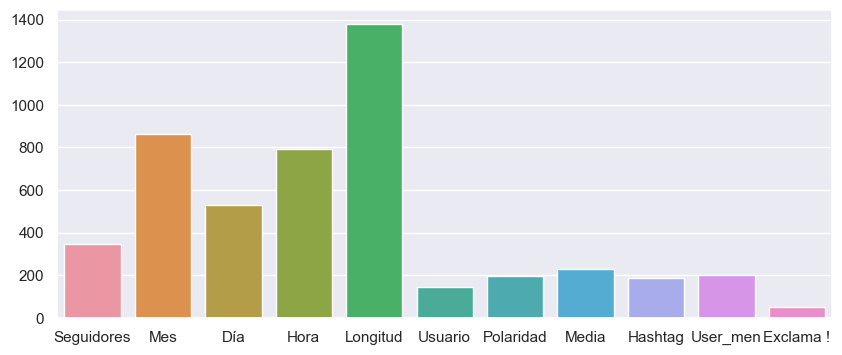

In [15]:
#Plot of the importance of each feature in the model that has been trained
columns= ["Seguidores","Mes", 'Día', 'Hora', 'Longitud', 'Usuario','Polaridad', 'Media', 'Hashtag', 'User_men', 'Exclama !']
plt.figure(figsize=(10,4))
fig = sns.barplot(x=columns, y=clas_model_lgbm[0].named_steps["model"].feature_importances_, width=0.8);

<AxesSubplot:>

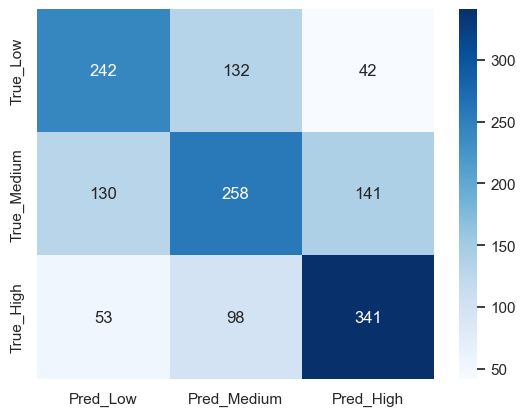

In [16]:
#Create confusion matrix and plot it with seaborn heatmap
c_matrix = confusion_matrix(y_test, y_pred_lgbm)

c_matrix_df = pd.DataFrame(c_matrix, 
                          columns=['Pred_Low', 'Pred_Medium', 'Pred_High'],
                          index=['True_Low', 'True_Medium', 'True_High'])
sns.heatmap(c_matrix_df, 
           annot=True,
           fmt='g',
           cmap="Blues")

#### RandomForest

In [26]:
#Predict with Random Forest and print confusion matrix
y_pred_rfc = clas_model_rfc[0].predict(X_test)
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.58      0.56      0.57       416
           1       0.54      0.51      0.52       529
           2       0.66      0.71      0.69       492

    accuracy                           0.59      1437
   macro avg       0.59      0.60      0.59      1437
weighted avg       0.59      0.59      0.59      1437



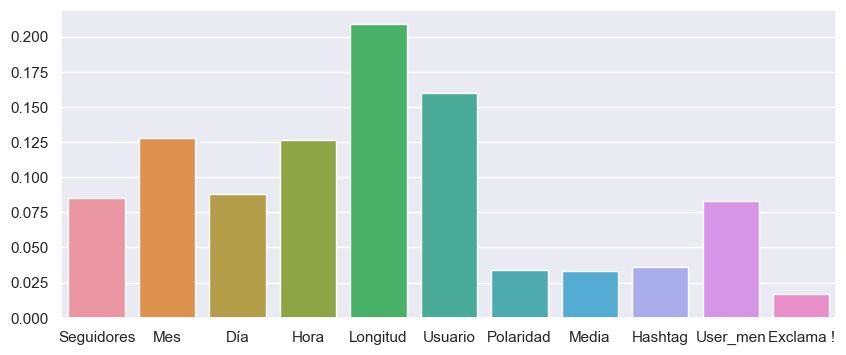

In [18]:
#Plot of the importance of each feature in the model that has been trained
columns= ["Seguidores","Mes", 'Día', 'Hora', 'Longitud', 'Usuario','Polaridad', 'Media', 'Hashtag', 'User_men', 'Exclama !']
plt.figure(figsize=(10,4))
fig = sns.barplot(x=columns, y=clas_model_rfc[0].named_steps["model"].feature_importances_, width=0.8);

<AxesSubplot:>

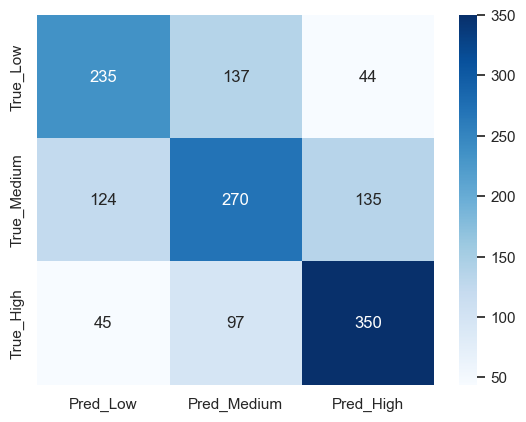

In [19]:
#Create confusion matrix and plot it with seaborn heatmap
c_matrix = confusion_matrix(y_test, y_pred_rfc)

c_matrix_df = pd.DataFrame(c_matrix, 
                          columns=['Pred_Low', 'Pred_Medium', 'Pred_High'],
                          index=['True_Low', 'True_Medium', 'True_High'])
sns.heatmap(c_matrix_df, 
           annot=True,
           fmt='g',
           cmap="Blues")